#A simple autoencoder test
Bottleneck consists of a single number, which determines the fraction of the image covered in black squares

In [3]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from matplotlib import pyplot as plt

tf.estimator package not installed.
tf.estimator package not installed.


In [32]:
# Decoder goes here
N_image = 28 # Size of (square) input image

def linear(x):
    # x represents the fraction of the image full of ones
    img = np.repeat(np.linspace(-1,1,28), N_image).reshape(N_image,N_image) * x
    return img

def ellipsoid(A,e,theta):
    B = A*(1.-e)
    x = np.tile(np.linspace(-1,1,28).reshape(1,28), (28,1))
    y = np.tile(-np.linspace(-1,1,28).reshape(28,1), (1,28))
    x_prime = x * np.cos(theta) - y * np.sin(theta)
    y_prime = x * np.sin(theta) + y * np.cos(theta)
    r_prime = np.sqrt((x_prime/A)**2 + (y_prime/B)**2)
    img = np.exp(-r_prime)
    return(img)

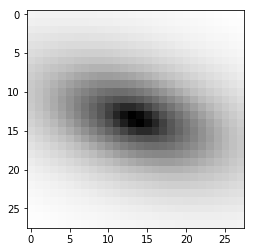

[[0.16230778 0.16477167 0.16664825 0.16790478 0.16851885 0.16847937
  0.16778706 0.16645441 0.16450512 0.16197312 0.15890107 0.15533876
  0.15134117 0.14696665 0.14227507 0.1373262  0.13217827 0.12688678
  0.12150363 0.11607645 0.1106482  0.10525697 0.09993597 0.09471362
  0.08961376 0.08465599 0.07985593 0.07522569]
 [0.18223946 0.1857089  0.1885     0.19056016 0.19184931 0.19234185
  0.19202787 0.19091369 0.18902153 0.18638839 0.18306427 0.17910989
  0.17459404 0.16959088 0.16417725 0.15843026 0.15242516 0.14623367
  0.13992261 0.13355306 0.12717978 0.12085096 0.11460824 0.10848691
  0.10251625 0.09671998 0.09111677 0.08572069]
 [0.20370716 0.20847933 0.21248394 0.21563976 0.21787993 0.21915539
  0.21943762 0.21872024 0.21701941 0.21437288 0.21083784 0.2064879
  0.20140928 0.19569686 0.18945014 0.18276959 0.17575346 0.16849526
  0.16108184 0.15359207 0.14609613 0.13865524 0.13132175 0.12413948
  0.11714429 0.11036476 0.10382293 0.09753502]
 [0.22646164 0.23289691 0.23848987 0.2431193

In [31]:
# And here's a test to see that the decoder does what we expect:
gal = ellipsoid(1.,0.5,0.3)
plt.imshow(gal, cmap="Greys")
plt.show()

print gal

In [100]:
#Making dataset
N_train = 10000
noise = 0.05

train_images = []
train_labels = []
for i in range(N_train):
    A = np.random.uniform()
    e = np.random.uniform()
    theta = np.random.uniform()*np.pi
    img = ellipsoid(A,e,theta) + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image)
    train_images.append(img)

train_images = np.array([train_images]).reshape(N_train,N_image,N_image,1)
#train_images_transposed = np.array([img.transpose() for img in train_images])
#train_images = np.concatenate((train_images, train_images_transposed))
#train_images = train_images.reshape(2*N_train,N_image,N_image,1)

In [101]:
print train_images.shape

(10000, 28, 28, 1)


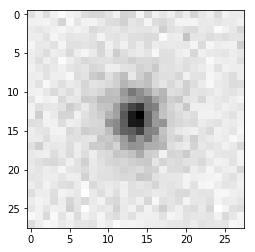

[-0.00681119  0.05838308  0.02591323  0.14435144  0.10578101  0.12971707
  0.13536845  0.14745044  0.29408305  0.29673804  0.42981958  0.49026588
  0.70335051  0.78645977  0.88453527  0.62202271  0.51871     0.4683829
  0.38469316  0.3269776   0.28132089  0.10992821  0.10101647  0.13978483
  0.053158    0.07960339  0.07516398  0.0140469 ]


In [102]:
# And here's a test to check that the training images are reasonable:
plt.imshow(train_images[10,:,:,0], cmap='Greys')
plt.show()
print train_images[4,int(N_image/2),:,0]

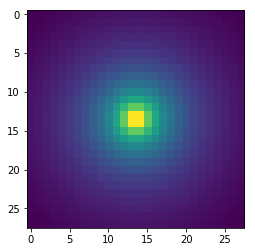

In [103]:
mean_image = np.mean(train_images,axis=0)[:,:,0]
plt.imshow(mean_image)
plt.show()

In [104]:
from __future__ import division

def normalize_meanstd(a, axis=None):
    # axis param denotes axes along which mean & std reductions are to be performed
    mean = np.mean(a, axis=axis, keepdims=True)
    std = np.sqrt(((a - mean)**2).mean(axis=axis, keepdims=True))
    return (a - mean) / std, mean, std

train_images_std, mean, std = normalize_meanstd(train_images, axis=(1,2))

In [105]:
#Lambda Layer (Decoder)
def make_linear(x):
    img = tf.tile(tf.reshape(tf.linspace(-1.,1.,N_image), [N_image,1,1]), [1,N_image,1])
    img = tf.tile(tf.reshape(img, [1,N_image,N_image,1]), [tf.shape(x)[0],1,1,1])
    img = tf.tile(tf.reshape(x, [tf.shape(x)[0],1,1,1]), [1,N_image,N_image,1]) * img
    return img

In [106]:
#Lambda Layer (Decoder, galaxies)
def ellipsoid_layer(X):
    A = tf.tile(tf.reshape(X[:,0], [tf.shape(X)[0],1,1,1]), [1,N_image,N_image,1])
    e = tf.tile(tf.reshape(X[:,1], [tf.shape(X)[0],1,1,1]), [1,N_image,N_image,1])
    theta = tf.tile(tf.reshape(X[:,2], [tf.shape(X)[0],1,1,1]), [1,N_image,N_image,1])
    
    B = A * (1. - e)
    
    x = tf.tile(tf.reshape(tf.linspace(-1.,1.,N_image), [1,N_image,1]), [N_image,1,1])
    y = - tf.tile(tf.reshape(tf.linspace(-1.,1.,N_image), [N_image,1,1]), [1,N_image,1])
    
    x = tf.tile(tf.reshape(x,[1,N_image,N_image,1]), [tf.shape(X)[0],1,1,1])
    y = tf.tile(tf.reshape(y,[1,N_image,N_image,1]), [tf.shape(X)[0],1,1,1])
    
    x_prime = x * tf.math.cos(theta) - y * tf.math.sin(theta)
    y_prime = x * tf.math.sin(theta) + y * tf.math.cos(theta)
    r_prime = tf.math.sqrt((x_prime/A)**2 + (y_prime/B)**2)
    
    img = tf.math.exp(-r_prime)
    
    return img

    #img = tf.tile(tf.reshape(img, [1,N_image,N_image,1]), [tf.shape(x)[0],1,1,1])
    #img = tf.tile(tf.reshape(x, [tf.shape(x)[0],1,1,1]), [1,N_image,N_image,1]) * img

In [107]:
model = models.Sequential()
filt_size = 3
fs = filt_size
model.add(layers.Conv2D(32, (fs, fs), activation='relu', padding="same", input_shape = (N_image,N_image,1),strides=(1,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))

model.add(layers.Flatten())
model.add(layers.Dense(3))

#model.add(layers.Dense(3136, activation='relu'))
#model.add(layers.Reshape((7, 7, 64)))

#model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
#model.add(layers.UpSampling2D((2, 2)))
#model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
#model.add(layers.UpSampling2D((2, 2)))
#model.add(layers.Conv2D(1, (fs, fs), activation='sigmoid', padding="same"))

#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(1))
model.add(layers.Lambda(lambda x:ellipsoid_layer(x)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 9411      
__________

In [108]:
model.compile(optimizer='RMSprop',
              loss='mean_squared_error',
              metrics=['accuracy']
             )
#model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

In [109]:
model.fit(train_images, train_images, epochs=5)
#model.fit(train_images, train_labels/10., epochs=5)

Epoch 1/5
10000/10000 [==============================] - 17s 2ms/step - loss: 0.2022 - acc: 0.0000e+00
Epoch 2/5
10000/10000 [==============================] - 20s 2ms/step - loss: 0.1454 - acc: 0.0000e+00
Epoch 3/5
10000/10000 [==============================] - 19s 2ms/step - loss: 0.1296 - acc: 0.0000e+00
Epoch 4/5
10000/10000 [==============================] - 21s 2ms/step - loss: 0.1227 - acc: 0.0000e+00
Epoch 5/5
10000/10000 [==============================] - 19s 2ms/step - loss: 0.1184 - acc: 0.0000e+00


In [139]:
test_img = ellipsoid(0.05,0.4,0.5).reshape(28,28,1)# + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image,1)
#test_img = test_img[:,:,0].transpose().reshape(28,28,1)
out = model.predict(np.array([test_img]))

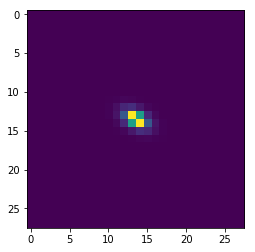

[7.57414713e-14 3.54479668e-13 1.49560516e-12 5.59115762e-12
 1.81651142e-11 5.02269707e-11 1.15678907e-10 2.17398234e-10
 3.27555910e-10 3.90744277e-10 3.66949978e-10 2.71842385e-10
 1.60373683e-10 7.65197982e-11 3.01080078e-11 9.97938568e-12
 2.84654058e-12 7.13006183e-13 1.59729056e-13 3.25232606e-14
 6.10342412e-15 1.06826806e-15 1.76147648e-16 2.75954516e-17
 4.13667353e-18 5.96919340e-19 8.33332576e-20 1.13033272e-20]


In [140]:
plt.imshow(test_img[:,:,0])
plt.show()
print test_img[:,0,0]

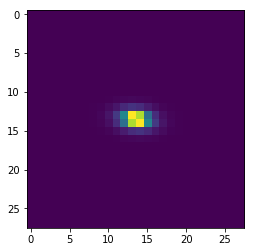

[1.17558025e-12 8.77279326e-12 6.54208493e-11 4.87416496e-10
 3.62717900e-09 2.69489551e-08 1.99777489e-07 1.47623325e-06
 1.08549939e-05 7.91809944e-05 5.69302589e-04 3.97265051e-03
 2.56470609e-02 1.23036295e-01 1.55113012e-01 3.81488577e-02
 6.11681910e-03 8.86431255e-04 1.23888211e-04 1.70268249e-05
 2.31896843e-06 3.14116733e-07 4.23990834e-08 5.70916203e-09
 7.67441444e-10 1.03030258e-10 1.38186624e-11 1.85201008e-12]


In [141]:
plt.imshow(out[0,:,:,0])
plt.show()
print out[0,:,15,0]
#print out

In [373]:
w = model.get_weights()
warr = np.array(w)
print warr[6].shape

(3136, 1)


(array([5.0000e+00, 1.2000e+01, 4.4000e+01, 1.3000e+02, 3.7600e+02,
        8.4000e+02, 1.9390e+03, 4.0880e+03, 8.0060e+03, 2.4094e+04,
        3.4213e+04, 3.6949e+04, 3.8892e+04, 3.9553e+04, 3.9769e+04,
        3.9195e+04, 3.8238e+04, 3.6332e+04, 3.1498e+04, 1.3983e+04,
        6.2750e+03, 3.4210e+03, 1.7680e+03, 8.6500e+02, 4.6000e+02,
        2.5000e+02, 1.2400e+02, 6.0000e+01, 2.2000e+01, 7.0000e+00]),
 array([-0.12523131, -0.11652011, -0.10780893, -0.09909773, -0.09038654,
        -0.08167534, -0.07296415, -0.06425296, -0.05554176, -0.04683057,
        -0.03811938, -0.02940818, -0.02069699, -0.0119858 , -0.0032746 ,
         0.00543659,  0.01414779,  0.02285898,  0.03157017,  0.04028137,
         0.04899256,  0.05770375,  0.06641494,  0.07512614,  0.08383733,
         0.09254853,  0.10125972,  0.10997091,  0.11868211,  0.1273933 ,
         0.1361045 ], dtype=float32),
 <a list of 30 Patch objects>)

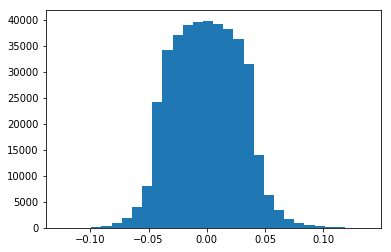

In [17]:
#plt.imshow(warr[6],aspect='auto')
plt.hist(warr[6].reshape(-1),bins=30)

In [19]:
# Run the following to see all the weights (filters) for one of the layers
#for i in np.arange(64):    
#    plt.imshow(w[2][:,:,0,i])
#    #plt.imshow(np.random.uniform(-1,1,9*9).reshape(9,9))
#    plt.show()

In [191]:
#Lambda Layer (Decoder) (TL's copy):
def make_regions(x):
    x_int = x[1]
    print x, tf.to_float(x_int)
    img = np.zeros(N_image*N_image).reshape(N_image,N_image)
    Q = int(np.floor(x_int*N_image))
    img[:,0:Q] = 1
    return img

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))
model.add(layers.Lambda(make_regions))

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                36928     
__________

In [5]:
# Here's the mnist train data, for reference:

#mnist_data = np.load('mnist.npz')
#(train_images, train_labels), (test_images, test_labels) = (mnist_data['x_train'], mnist_data['y_train']), (mnist_data['x_test'], mnist_data['y_test'])

In [6]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


In [66]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [15]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [18]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                36928     
__________

In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
 2400/60000 [>.............................] - ETA: 3:03 - loss: 1.0760 - acc: 0.6562

60000/60000 [==============================] - 134s 2ms/step - loss: 0.0197 - acc: 0.9940


In [23]:
model.predict_classes(np.array([test_images[0]]))

array([7])

In [24]:
test_labels[0]

7

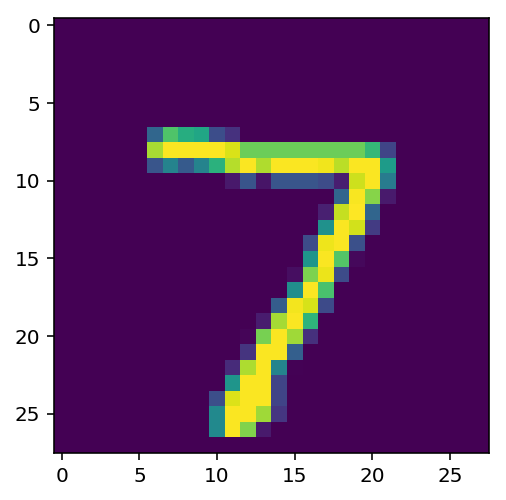

In [28]:
import matplotlib.pyplot as plt
plt.imshow(test_images[0][:,:,0])